In [1]:
import sys
sys.path.append('../gtm/')
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
import random
import torch
import pandas as pd
from tqdm import tqdm
from corpus import GTMCorpus
from gtm import GTM
from joblib import Parallel, delayed
import numpy as np

/home/germain/Documents/topic models/generalized_topic_model_dev/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
num_docs = 10000
num_docs_bis = 500
num_topics = 6
vocab_size = 500
min_words = 100
max_words = 100
num_covs = 0
doc_topic_prior = 'logistic_normal'

gtm_model_args = {
        "n_topics":num_topics,
        "num_epochs":1000,
        "update_prior":False,
        "doc_topic_prior":doc_topic_prior,
        "encoder_hidden_layers":[128], 
        "decoder_hidden_layers":[],
        "print_every_n_epochs":10000,
        "log_every_n_epochs":10,
        "print_topics":False,
        "w_prior":1000,
        "patience":10,
        "learning_rate":1e-3,
        "batch_size":64,
        "num_epochs":150,
        "dropout":0,
        "device":None,
        "seed":42
        }

if doc_topic_prior == 'logistic_normal':
    lambda_ = np.array(
        [[0,0.3],
        [0,-1]]
    )
    sigma = np.array(
        [[1.7,-0.3],
        [-0.3,2.3]]
    )
else:
    lambda_ = np.array(
        [[-2,0.01],
        [-2,0.02]]
    )
    sigma = None

In [3]:
def generate_docs_vectorized(
    true_doc_topic_matrix, topic_word_matrix, min_words, max_words, num_docs
):
    doc_lengths = np.random.randint(min_words, max_words + 1, size=num_docs)
    max_length = np.max(doc_lengths)
    
    # Create a matrix of word probabilities for all documents
    word_probs = np.dot(true_doc_topic_matrix, topic_word_matrix)
    word_probs /= np.sum(word_probs, axis=1, keepdims=True)
    
    # Generate word indices for all documents
    random_values = np.random.random((num_docs, max_length))
    cumulative_probs = np.cumsum(word_probs, axis=1)
    word_indices = np.argmax(random_values[:, :, np.newaxis] < cumulative_probs[:, np.newaxis, :], axis=2)
    
    # Create a mask for valid words based on document lengths
    mask = np.arange(max_length)[np.newaxis, :] < doc_lengths[:, np.newaxis]
    
    # Generate words and join them into documents
    words = np.core.defchararray.add('word_', word_indices.astype(str))
    docs = np.array([' '.join(doc[mask[i]]) for i, doc in enumerate(words)])
    
    return docs

def generate_anchor_words(num_topics, vocab_size, anchor_words_per_topic):
    anchor_words = {}
    available_words = set(range(vocab_size))
    
    for topic in range(num_topics):
        if len(available_words) < anchor_words_per_topic:
            raise ValueError("Not enough unique words for anchor words")
        
        topic_anchors = set(random.sample(available_words, anchor_words_per_topic))
        anchor_words[topic] = topic_anchors
        available_words -= topic_anchors
    
    return anchor_words

def generate_documents(
    num_docs,
    num_topics,
    vocab_size,
    num_covs=0,
    beta=None,
    lambda_=None,
    sigma_y=0.1,
    sigma_topic=None,
    doc_topic_prior='dirichlet',
    min_words=50,
    max_words=500,
    random_seed=None,
    include_y=False,
    anchor_words_per_topic=1  # New parameter
):
    if random_seed is not None:
        np.random.seed(random_seed)
        random.seed(random_seed)
    
    topicnames = [f"Topic{i}" for i in range(num_topics)]
    docnames = [f"Doc{i}" for i in range(num_docs)]
    words = [f"word_{i}" for i in range(vocab_size)]
    cov_names = ["intercept"] + [f"cov_{i}" for i in range(num_covs)]
    
    # Generate covariates
    if num_covs > 0:
        M_prevalence_covariates = np.column_stack((
            np.ones(num_docs),
            np.random.randint(2, size=(num_docs, num_covs))
        ))
    else:
        M_prevalence_covariates = np.ones((num_docs, 1))
    
    # Generate document-topic matrix
    if doc_topic_prior == 'dirichlet':
        if num_covs > 0 and lambda_ is not None:
            alpha = np.exp(np.dot(M_prevalence_covariates, lambda_))
        else:
            alpha = np.ones((num_docs, num_topics)) * 0.1
        true_doc_topic_matrix = np.array([np.random.dirichlet(a) for a in alpha])
    else:
        if num_covs > 0 and lambda_ is not None:
            mean = np.dot(M_prevalence_covariates, lambda_)
        else:
            mean = np.zeros((num_docs, num_topics))
        if sigma_topic is None:
            sigma_topic = np.eye(num_topics)
        samples = []
        for m in mean:
            sample = np.random.multivariate_normal(m, sigma_topic)
            sample = np.exp(sample) / np.exp(sample).sum()
            samples.append(sample)
        true_doc_topic_matrix = np.array(samples)
    
    # Generate anchor words
    anchor_words = generate_anchor_words(num_topics, vocab_size, anchor_words_per_topic)
    
    # Generate topic-word matrix with anchor words
    topic_word_matrix = np.zeros((num_topics, vocab_size))
    for topic in range(num_topics):
        # Identify words that can appear in this topic
        valid_words = list(anchor_words[topic].union(set(range(vocab_size)) - set().union(*anchor_words.values())))
        
        # Generate distribution for valid words
        dirichlet_params = np.ones(len(valid_words)) * 0.1
        topic_distribution = np.random.dirichlet(dirichlet_params)
        
        # Place the distribution in the correct positions in the topic-word matrix
        topic_word_matrix[topic, valid_words] = topic_distribution
    
    # Normalize the topic-word matrix
    topic_word_matrix /= topic_word_matrix.sum(axis=1, keepdims=True)
    
    # Generate documents
    documents = generate_docs_vectorized(
        true_doc_topic_matrix,
        topic_word_matrix,
        min_words,
        max_words,
        num_docs
    )
    
    # Create DataFrame
    df = pd.DataFrame({"doc": documents, "doc_clean": documents})
    
    # Add covariates to DataFrame
    if num_covs > 0:
        df = pd.concat([df, pd.DataFrame(M_prevalence_covariates, columns=cov_names)], axis=1)
    
    # Generate y if requested
    if include_y:
        if beta is None:
            beta = np.random.normal(0, 1, num_topics)
        y = np.dot(true_doc_topic_matrix, beta) + np.random.normal(0, sigma_y, num_docs)
        df['y'] = y
    
    # Create true distribution DataFrames
    df_doc_topic = pd.DataFrame(true_doc_topic_matrix, columns=topicnames, index=docnames)
    df_topic_word = pd.DataFrame(topic_word_matrix, index=topicnames, columns=words)
    df_true_dist_list = [df_doc_topic, df_topic_word]
    
    return df_true_dist_list, df, anchor_words

In [4]:
dict_betas = {}
    
df_true_dist_list_gtm, df, anchor_words = generate_documents(
    num_docs,
    num_topics,
    vocab_size,
    num_covs=0,
    beta=None,
    lambda_=None,
    sigma_y=0.1,
    sigma_topic=None,
    doc_topic_prior='logistic_normal',
    min_words=min_words,
    max_words=min_words,
    random_seed=42,
    include_y=False,
    anchor_words_per_topic=10  # New parameter
)  

full_dataset = GTMCorpus(
    df,
)

tm = GTM(
    train_data = full_dataset,
    **gtm_model_args
)
    
df_doc_topic_gtm = pd.DataFrame(
        tm.get_doc_topic_distribution(full_dataset),
        index=["Doc{}".format(i) for i in range(num_docs)],
        columns=["Topic{}".format(i) for i in range(num_topics)],
    )
true_df = df_true_dist_list_gtm[0]
estimated_df = df_doc_topic_gtm

### matching the columns of estimated doc_topic dist with those of true doc_topic dist by maximizing dot-product
score_list = []
for true_col in true_df.columns:
    true_target_col = true_df.loc[:, true_col]
    score_list_per_row = []
    for col in estimated_df.columns:
        target_col = estimated_df.loc[:, col]
        score_list_per_row.append(np.dot(target_col, true_target_col))
    score_list.append(score_list_per_row)
    
corres_num_topic_dict_gtm = {}
corres_num_topic_dict_gtm_bis = {}
score_matrix = pd.DataFrame(score_list)
true_topics, estimated_topics = linear_sum_assignment(-score_matrix)
for true_topic, estimated_topic in zip(true_topics, estimated_topics):
    corres_num_topic_dict_gtm["Topic{}".format(true_topic)] = "Topic{}".format(
        estimated_topic
    )
    corres_num_topic_dict_gtm_bis[true_topic] = estimated_topic
    
reanged_df_gtm = estimated_df.loc[:, corres_num_topic_dict_gtm.values()]
reanged_df_gtm.columns = corres_num_topic_dict_gtm.keys()

/tmp/ipykernel_36644/502162189.py:33: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  topic_anchors = set(random.sample(available_words, anchor_words_per_topic))



Stopping at Epoch 44. Reverting to Epoch 44


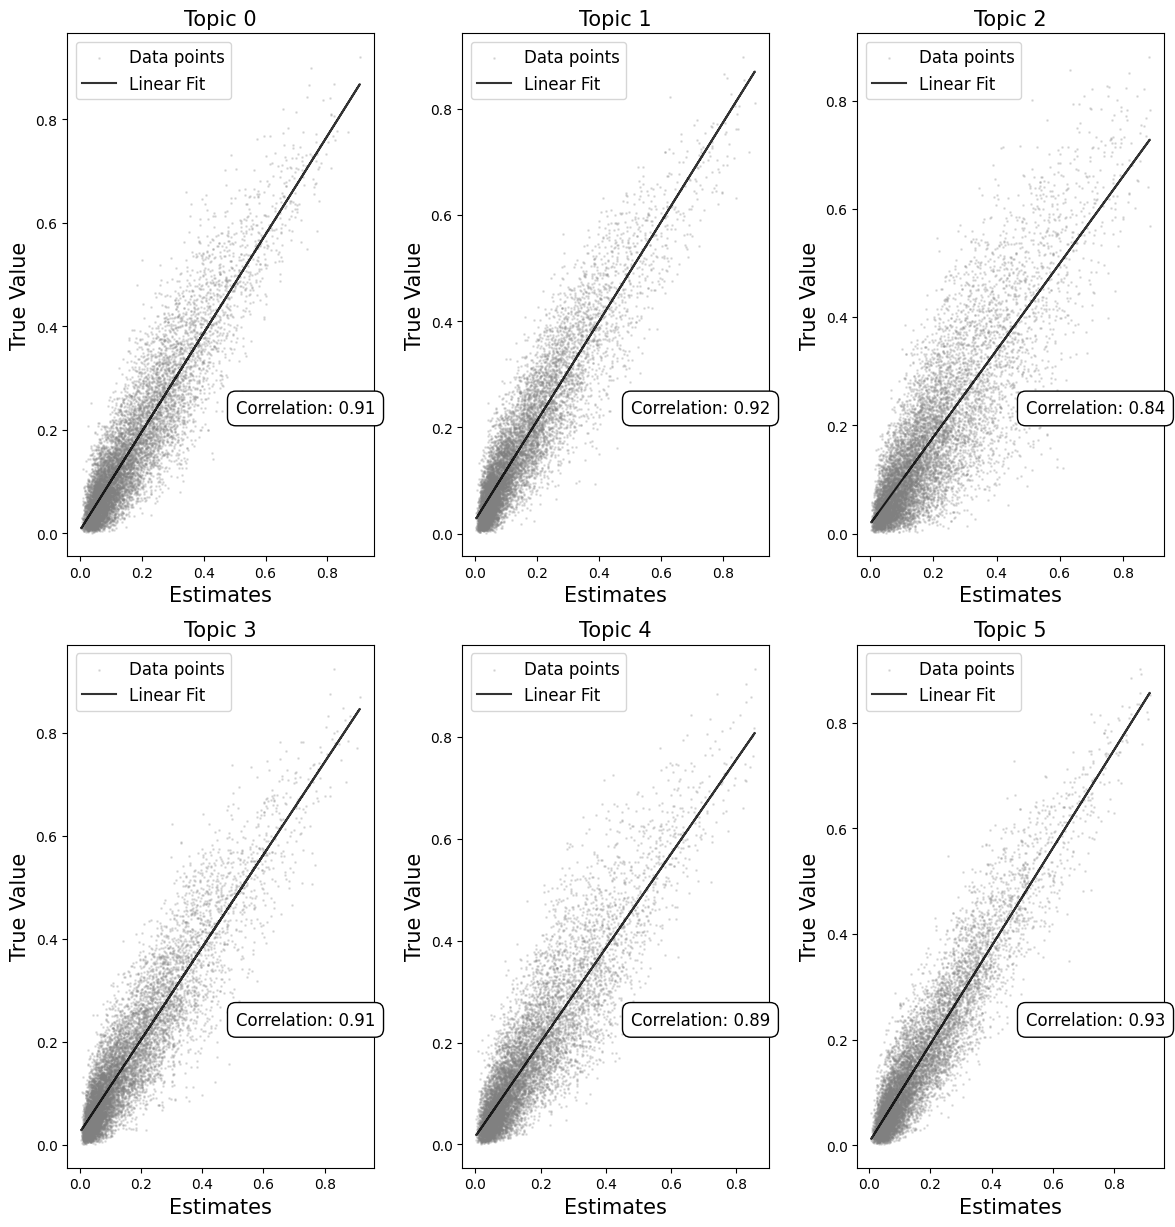

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Define the number of topics
num_topics = len(reanged_df_gtm.columns)  # Assuming each column corresponds to a topic

# Define grid dimensions: 2 figures per row
n_cols = 3
n_rows = (num_topics + 1) // 2  # This ensures you have enough rows to accommodate all topics

# Create subplots with the grid layout
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 6*n_rows)) 

# Flatten the axs array to handle it as a 1D list
axs = axs.flatten()

for i in range(num_topics):  
    x = reanged_df_gtm['Topic{}'.format(i)]
    y = true_df['Topic{}'.format(i)]
    
    axs[i].scatter(x, y, label='Data points', s=1, color='grey', alpha=0.2)
    coefficients = np.polyfit(x, y, 1)
    fit = np.poly1d(coefficients)
    axs[i].plot(x, fit(x), color='black', label='Linear Fit', alpha=0.8)
    axs[i].set_xlabel('Estimates', fontsize=15)
    axs[i].set_ylabel('True Value', fontsize=15)
    axs[i].set_title('Topic {}'.format(i), fontsize=15)
    axs[i].legend(fontsize=12)

    # Calculate correlation coefficient
    corr_coeff = np.corrcoef(x, y)[0, 1]
    # Add annotation
    axs[i].annotate(f'Correlation: {corr_coeff:.2f}', xy=(0.55, 0.3), xycoords='axes fraction',
                 fontsize=12, verticalalignment='top', horizontalalignment='left',
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Hide any unused subplots if num_topics is odd
for j in range(num_topics, n_rows * n_cols):
    fig.delaxes(axs[j])

plt.tight_layout() 
plt.savefig('../figs/true_vs_estimated_sample_{}_{}.pdf'.format(doc_topic_prior, num_topics))